In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datasets
## Deliveries 
Wykorzystanie: Po złączeniu z danymi z products możemy zauważyć kiedy zamawiane jest najwięcej produktów.

In [213]:
delivery_df = pd.read_json("./../data/raw/deliveries.jsonl", lines=True)
delivery_df.set_index('purchase_id', inplace=True)
delivery_df = delivery_df.replace([np.inf, -np.inf], np.nan)
delivery_df = delivery_df.dropna(subset=["delivery_company", 'delivery_timestamp'])
delivery_df['purchase_timestamp'] = pd.to_datetime(delivery_df['purchase_timestamp'])
delivery_df['delivery_timestamp'] = pd.to_datetime(delivery_df['delivery_timestamp'])
delivery_df['delivery_company'] = delivery_df["delivery_company"].astype(int)
delivery_df


,purchase_timestamp,delivery_timestamp,delivery_company
purchase_id,,,
20001,2019-12-30 09:36:24,2020-01-03 09:38:59,516
20002,2019-12-31 23:15:05,2020-01-04 23:19:26,516
20003,2019-12-31 15:32:45,2020-01-05 15:34:16,516
20004,2019-12-31 14:39:52,2020-01-02 14:40:49,516
20005,2019-12-30 03:19:36,2020-01-04 03:21:24,360
...,...,...,...
37399,2021-01-01 01:51:17,2021-01-03 01:54:02,360
37400,2021-01-02 12:37:29,2021-01-06 12:40:42,360
37401,2021-01-02 06:42:06,2021-01-07 06:46:20,360


## Products 
Wykorzystanie: możemy sprawdzać jakie kategorie produktów są najpopularniejsze - i w jakim czasie (łącząc ten dataset z deliveries) oraz do jakiej ceny. Przerobić kolumne category_path, join products z sessions i sprawdzić popularność po kategoriach, oraz częstość zakupów  

In [214]:
product_df = pd.read_json("./../data/raw/products.jsonl", lines=True)
product_df.set_index('product_id', inplace=True)
product_df = product_df.replace([np.inf, -np.inf], np.nan)
product_df = product_df.dropna(subset=["price"])
product_df = product_df[product_df.price >= 0]
product_df

,product_name,category_path,price
product_id,,,
1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...
1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99
1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,249.00
1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96


## Sessions 
Wykorzystanie: jakie produkty mają największe wzięcie, też jak często są wyświetlane   
Pytania: Jak zniżka wpływa na szybkie zniknięcie towaru z magazynu? Jeśli jest planowana, to ile więcej należy kupić rzeczy z danej kategorii? 

In [215]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)
sessions_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
124,2019-12-31 20:23:33,103,1114,VIEW_PRODUCT,5,NaN
124,2019-12-31 20:27:12,103,1136,VIEW_PRODUCT,5,NaN
124,2019-12-31 20:30:41,103,1088,VIEW_PRODUCT,5,NaN
124,2019-12-31 20:35:19,103,1054,VIEW_PRODUCT,5,NaN
124,2019-12-31 20:36:45,103,1091,VIEW_PRODUCT,5,NaN
...,...,...,...,...,...,...
46764,2021-01-02 23:47:34,395,1070,VIEW_PRODUCT,20,NaN
46764,2021-01-02 23:51:55,395,1039,VIEW_PRODUCT,20,NaN
46764,2021-01-02 23:55:05,395,1038,VIEW_PRODUCT,20,NaN


## Users
Wykorzystanie: możemy spróbować znaleźć zależność jacy użytkownicy (skąd pochodzący) jakie produkty kupują, dzięki temu w zależności od aktywnych użytkowników w ostatnim czasie i ich miejsca zamieszkania możemy stwierdzić czego prawdopodobnie będą potrzebować.

In [216]:
users_df = pd.read_json("./../data/raw/users.jsonl", lines=True)
users_df

,user_id,name,city,street
0,102,Monika Forysiak,Poznań,plac Dębowa 11/53
1,103,Kacper Malewicz,Wrocław,aleja Browarna 79/72
2,104,Tomasz Janiuk,Kraków,ulica Cegielniana 318
3,105,Roksana Mućka,Radom,plac Perłowa 48
4,106,Wiktor Jarka,Warszawa,al. Bema 37
...,...,...,...,...
295,397,Miłosz Herbut,Gdynia,ulica Grottgera 24/10
296,398,Sonia Bracha,Gdynia,aleja Lisia 10/42
297,399,Janina Helman,Warszawa,al. Listopada 13/10
298,400,Elżbieta Dub,Szczecin,plac Miłosza 84


# Wykresy danych

In [217]:
def show_plot_for_years(years, x_list, y_list, title, rotation=0):
    N = len(x_list)
    ind = np.arange(N) 
    width = 0.25
    plt.figure(figsize = (20, 7))
    plots = []
    for index, y in enumerate(y_list):
        plots.append(plt.bar(ind+width*index, y, width))
    plt.legend(plots, years)
    plt.xticks(ind+width, x_list, rotation=rotation)
    plt.title(title)
    plt.show()

###  Liczba zamówień w danym miesiącu

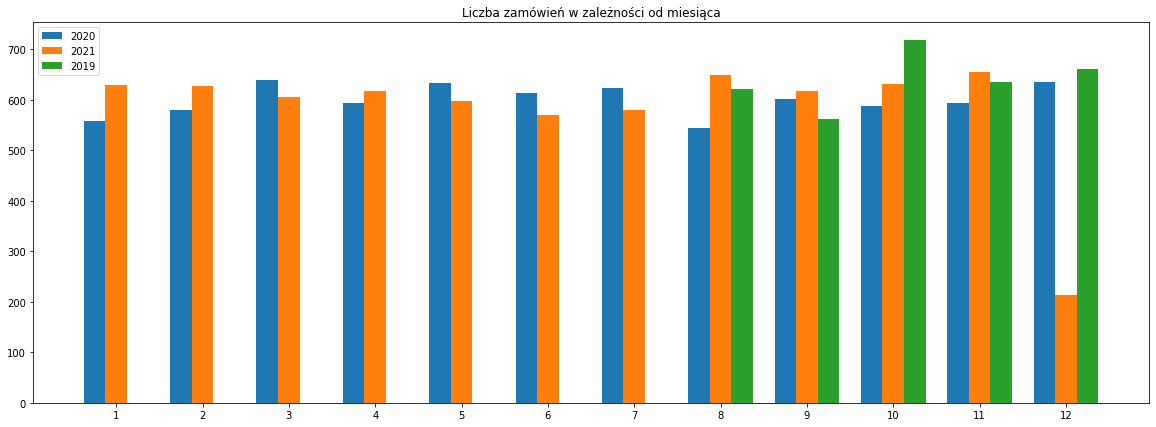

In [218]:
years = delivery_df["purchase_timestamp"].dt.year.value_counts().to_dict().keys()
months = range(1, 13)

df_list = []
for index, year in enumerate(years):
    delivery_year =  delivery_df[delivery_df.purchase_timestamp.dt.year.eq(year)]
    df = delivery_year.groupby(delivery_year["purchase_timestamp"].dt.month)["purchase_timestamp"].count().to_dict()
    
    for num_month in months:
        if num_month not in df.keys(): 
            df[num_month] = 0 
            
    df_list.append([j for _,j in sorted(df.items())])


show_plot_for_years(years, months, df_list, "Liczba zamówień w zależności od miesiąca")

Liczba zamiawianych produktów jest podobna w każdym miesiącu. Niewiele większa liczba produktów jest zamawiana w okresie jesienno - ziomowym.

###  Liczba zamówień z danej kategorii

In [219]:
purchase_from_category_df = pd.merge(sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"], product_df, on='product_id', how='inner')
purchase_from_category_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2019-12-30 09:36:24,109,1006,BUY_PRODUCT,0,20001.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
1,2019-12-31 20:04:42,143,1006,BUY_PRODUCT,5,20006.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
2,2019-12-30 19:53:54,201,1006,BUY_PRODUCT,15,20013.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
3,2019-12-30 02:40:53,269,1006,BUY_PRODUCT,20,20022.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
4,2019-12-30 18:26:55,370,1006,BUY_PRODUCT,5,20036.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
...,...,...,...,...,...,...,...,...,...
17398,2021-06-13 11:08:10,241,1082,BUY_PRODUCT,5,33610.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99
17399,2021-07-19 06:36:07,377,1082,BUY_PRODUCT,20,34423.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99
17400,2021-08-27 09:12:44,141,1082,BUY_PRODUCT,5,35036.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99
17401,2021-09-06 02:15:52,236,1082,BUY_PRODUCT,10,35399.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99


<AxesSubplot:title={'center':'Liczba zamówionych produktów z kategorii'}, xlabel='category_path'>

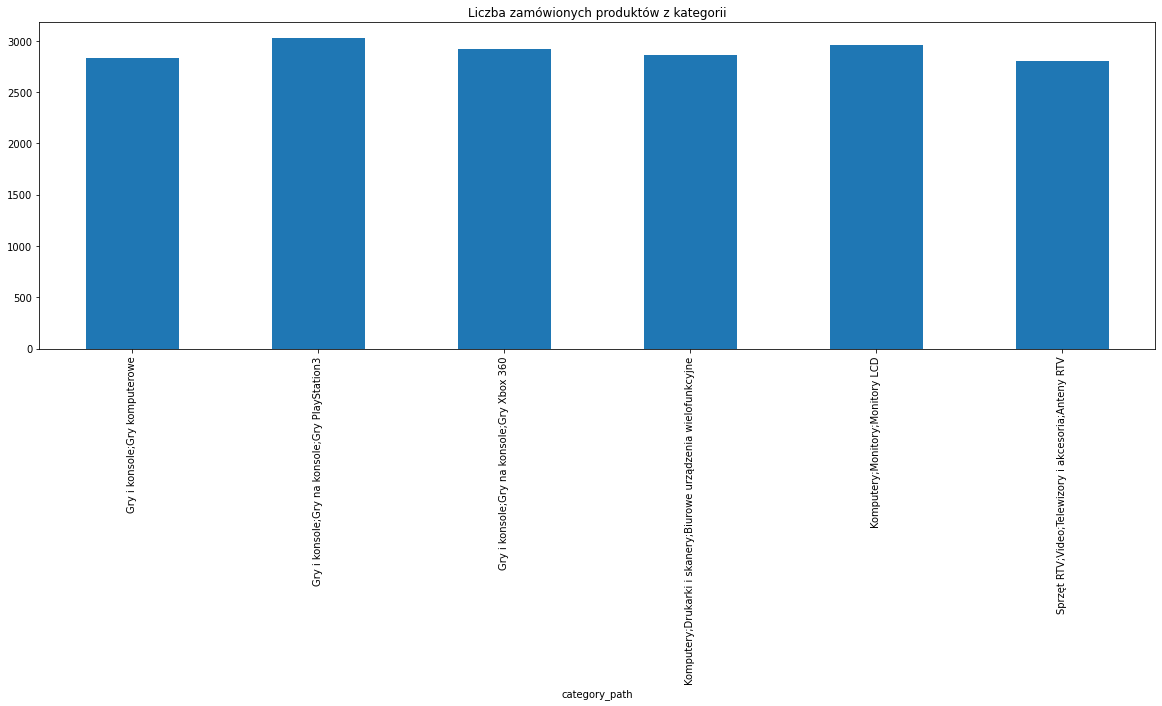

In [220]:
fig, axs = plt.subplots(figsize=(20, 6))
purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().plot(kind='bar', rot=90, ax=axs, title="Liczba zamówionych produktów z kategorii")

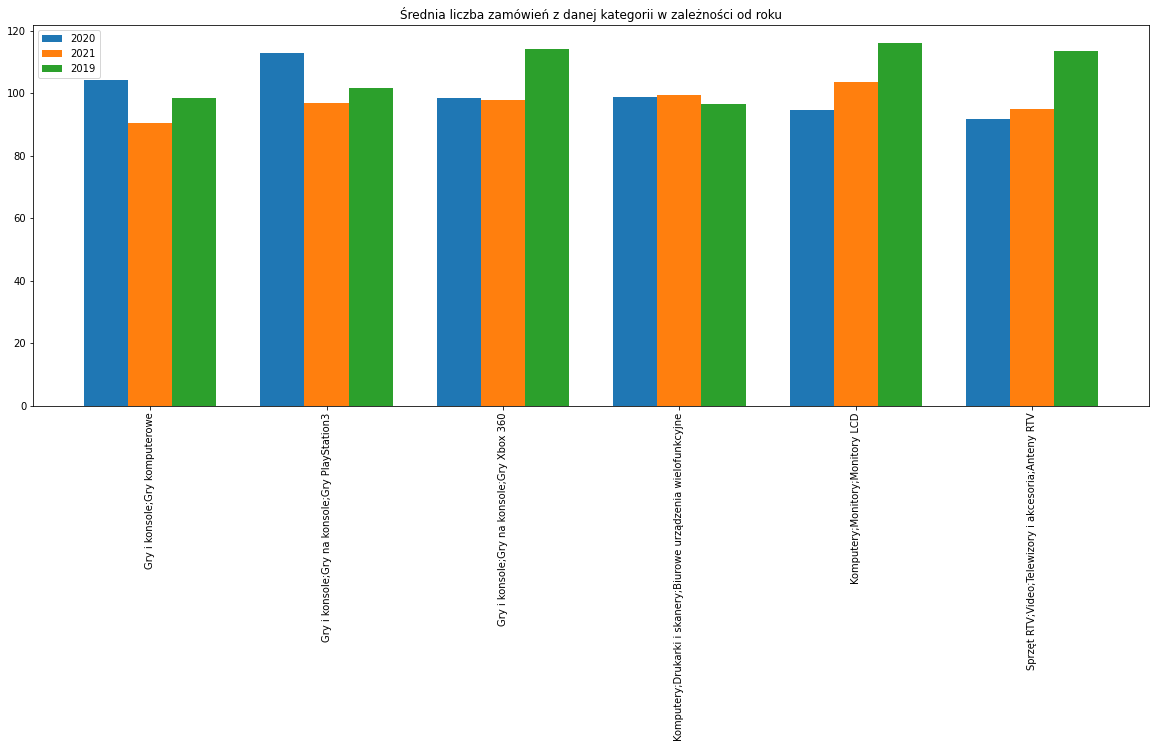

In [221]:
years = purchase_from_category_df["timestamp"].dt.year.value_counts().to_dict().keys()
categories = purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().to_dict().keys()
df_list = []
for index, year in enumerate(years):
    purchase_from_category_year = purchase_from_category_df[purchase_from_category_df.timestamp.dt.year.eq(year)]
    df = purchase_from_category_year.groupby(purchase_from_category_year["category_path"])["category_path"].count().to_dict()
    month_amount = len(purchase_from_category_year.groupby(purchase_from_category_year['timestamp'].dt.month)["timestamp"].count())
    df = dict(sorted(df.items())).values()
    df_list.append(np.divide(list(df), month_amount))

show_plot_for_years(years, categories, df_list, "Średnia liczba zamówień z danej kategorii w zależności od roku", rotation=90)

Liczba zamawianych produktów w każdej z kategorii jest podobna.

### Liczba zamówień danych produktów

In [222]:
product_purchase_df = pd.merge(sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"], product_df, on='product_id', how='inner')

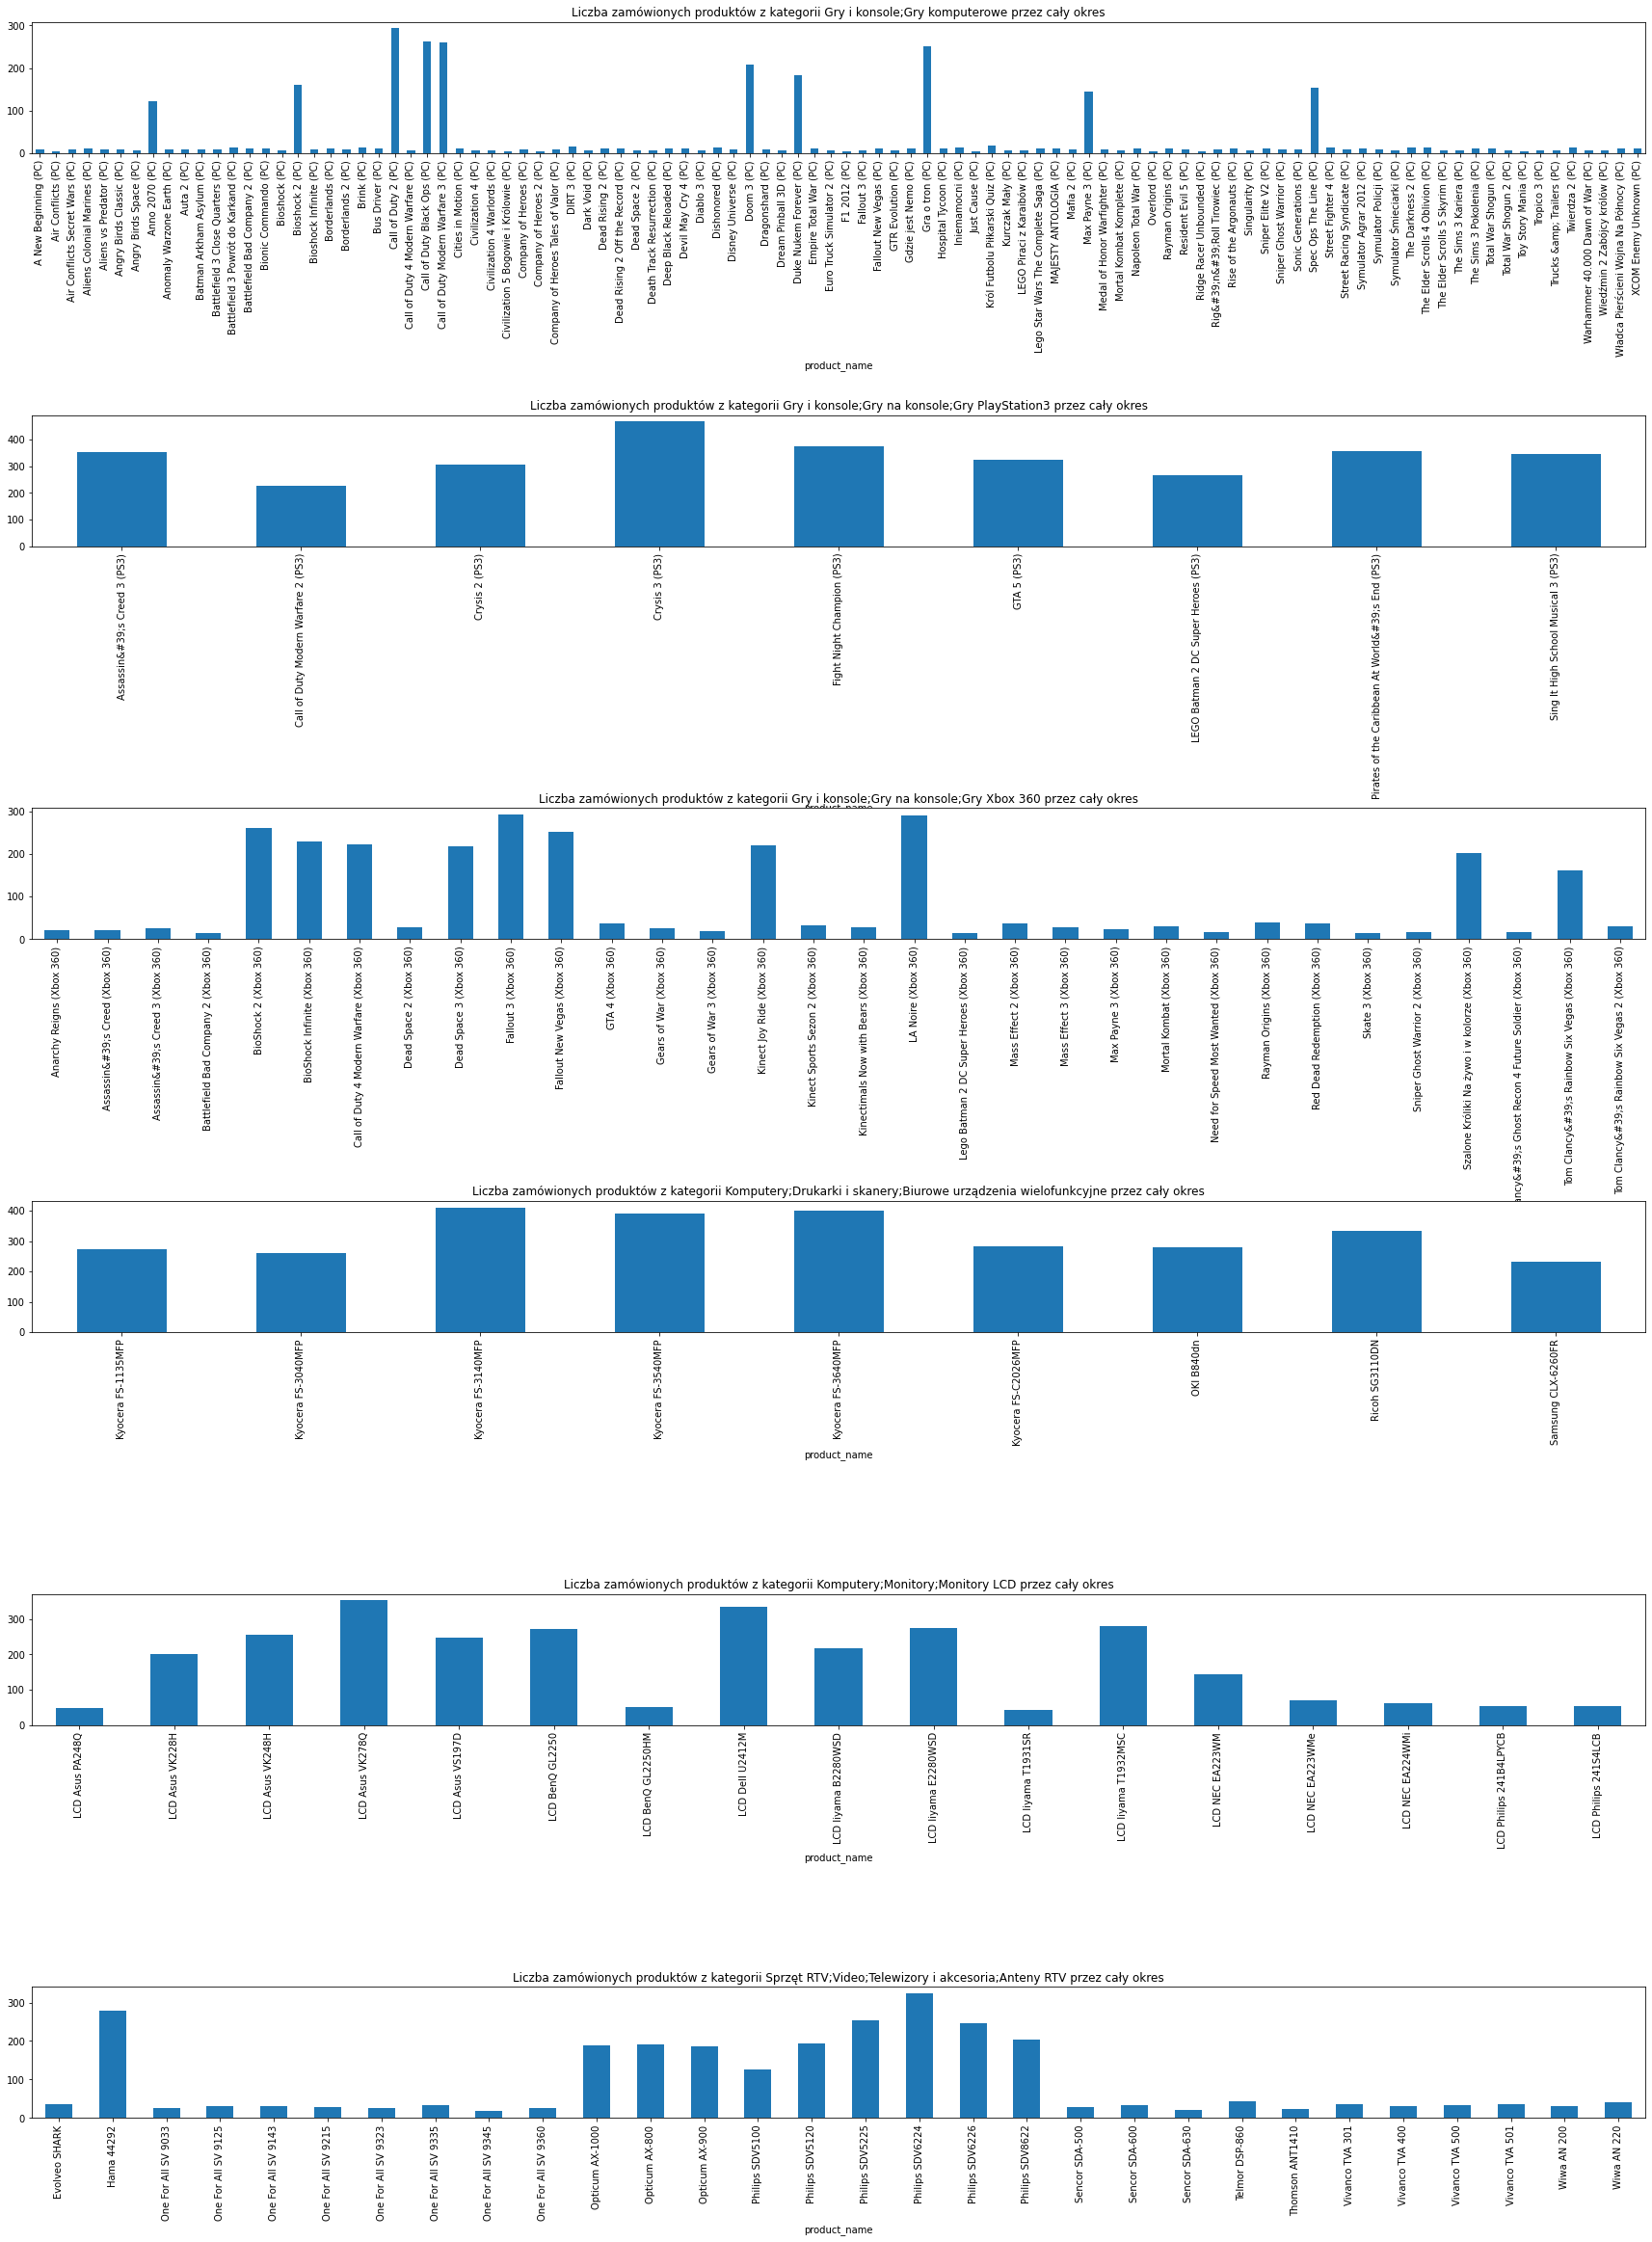

In [223]:
categories = purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().to_dict().keys()
fig, axs = plt.subplots(len(categories), figsize=(30, 40))
plt.subplots_adjust(hspace=2)
for index, category in enumerate(categories):
    product_purchase_one_category_df = product_purchase_df[product_purchase_df['category_path'] ==  category]
    product_purchase_one_category_df.groupby(product_purchase_one_category_df["product_name"])["category_path"].count().plot(kind='bar', rot=90, ax=axs[index], title=f"Liczba zamówionych produktów z kategorii {category} przez cały okres")

Lista 10 najpopularniejszych produktów

In [224]:
popular_products = product_purchase_one_category_df.groupby(product_purchase_one_category_df["product_name"])["product_name"].count().to_frame()
print("Najpopularniejsze produkty")
popular_products.nlargest(10, "product_name")

Najpopularniejsze produkty


,product_name
product_name,
Philips SDV6224,324
Hama 44292,279
Philips SDV5225,253
Philips SDV6226,247
Philips SDV8622,203
Philips SDV5120,193
Opticum AX-800,192
Opticum AX-1000,188
Opticum AX-900,186


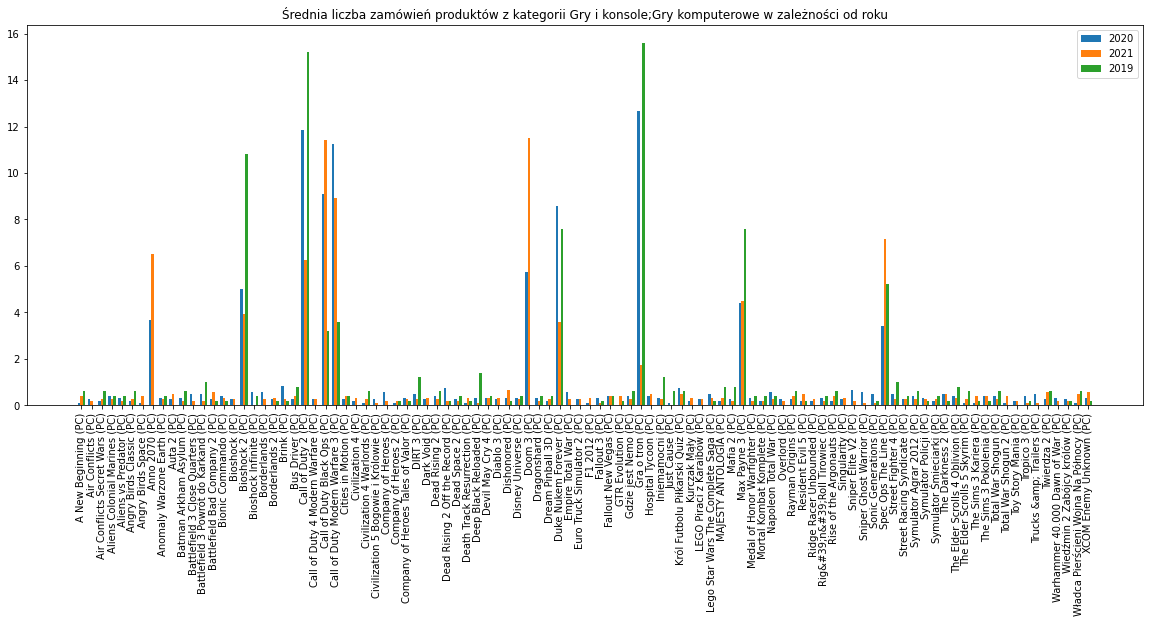

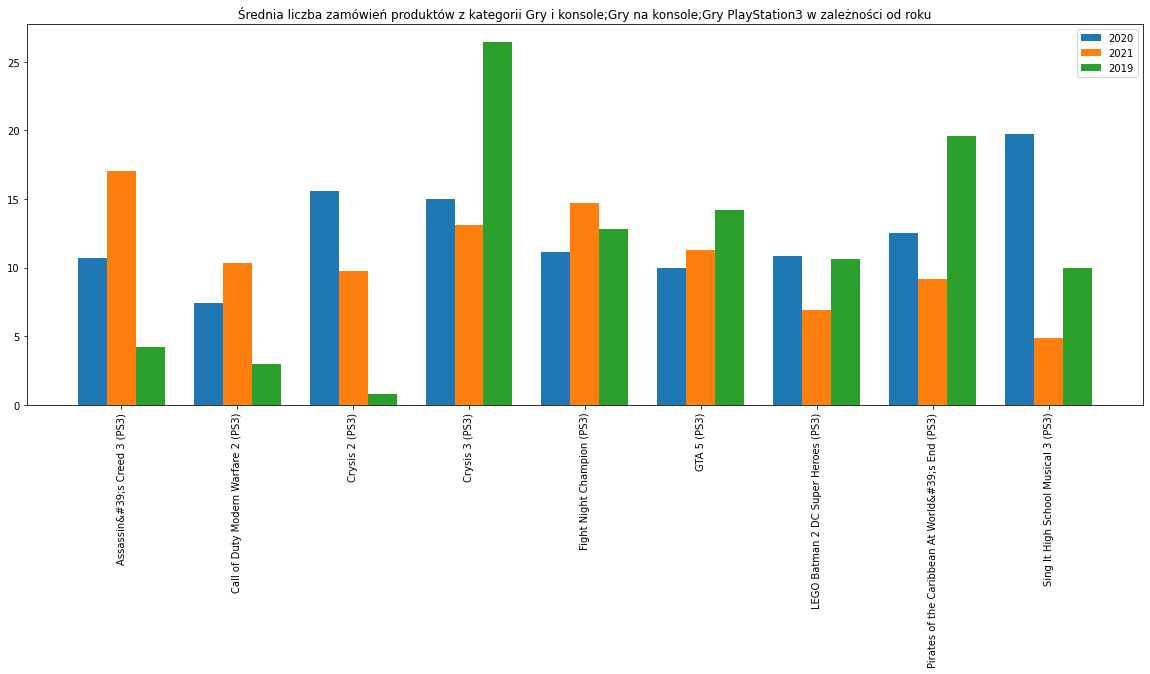

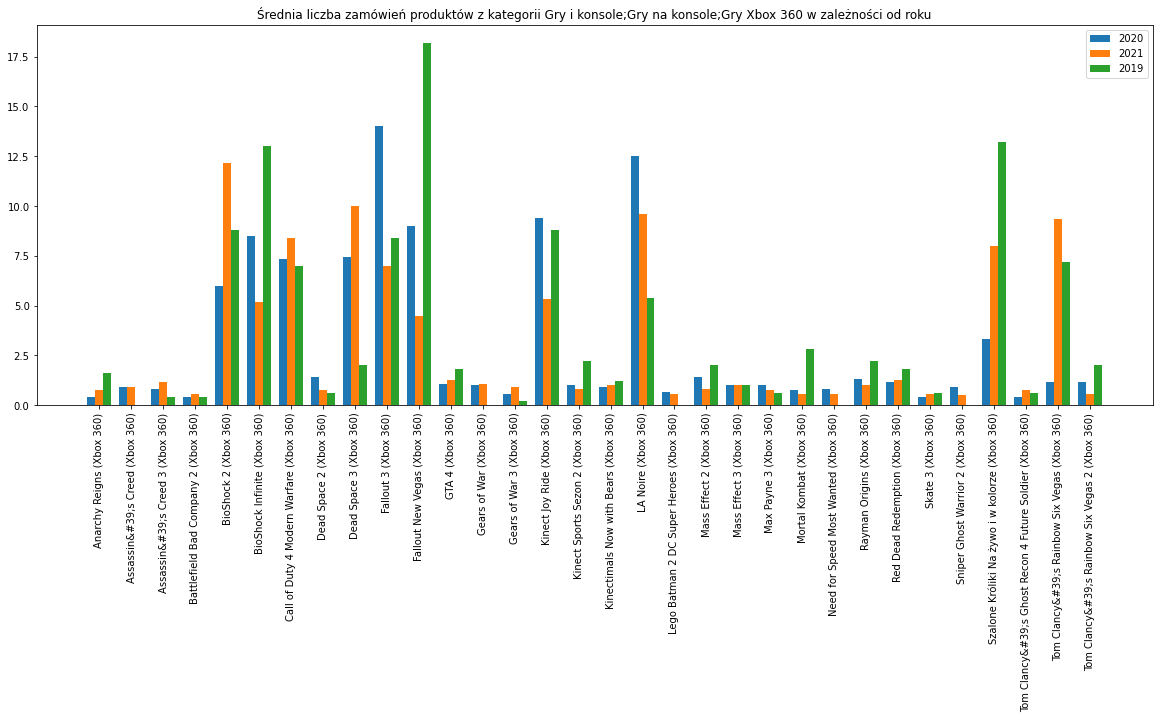

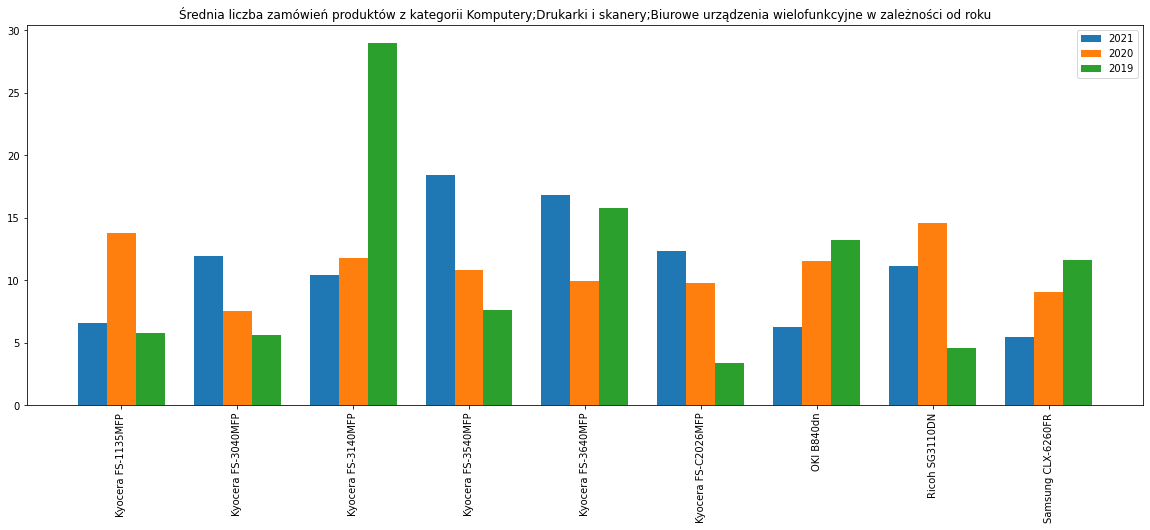

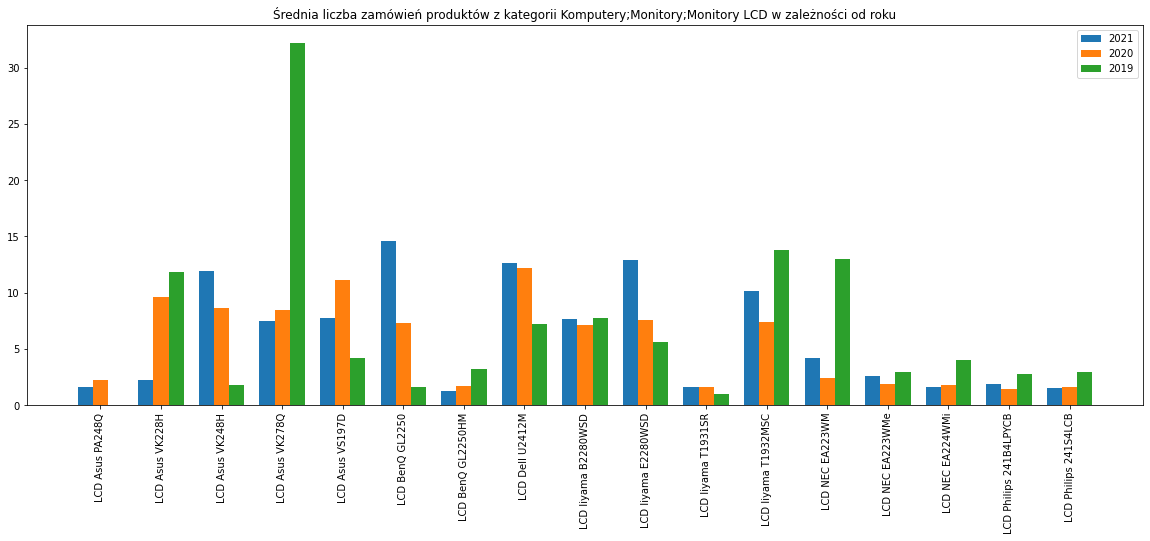

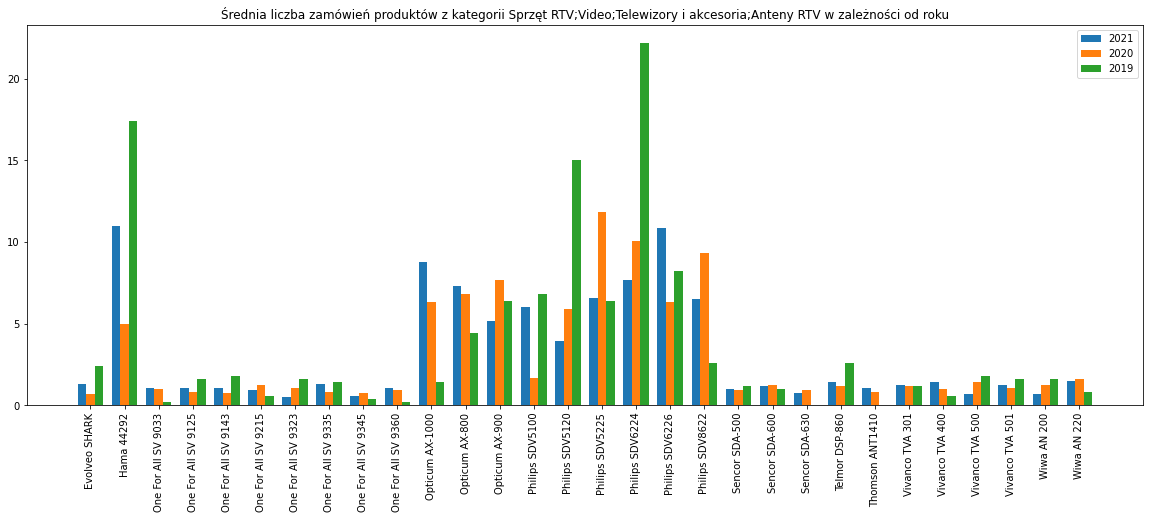

In [225]:
def get_plot_for_product_grouped_by_category(product_purchase_df):
    years = product_purchase_df["timestamp"].dt.year.value_counts().to_dict().keys()
    products = product_purchase_df.groupby(product_purchase_df["product_name"])["product_name"].count().to_dict().keys()
    df_list = []
    for index, year in enumerate(years):
        product_purchase_year = product_purchase_df[product_purchase_df.timestamp.dt.year.eq(year)]
        df = product_purchase_year.groupby(product_purchase_year["product_name"])["product_name"].count().to_dict()
        left = [item for item in products if item not in df.keys()]
        for i in left:
            df[i] = 0
        month_amount = len(product_purchase_year.groupby(product_purchase_year['timestamp'].dt.month)["timestamp"].count())
        df = dict(sorted(df.items())).values()
        df_list.append(np.divide(list(df), month_amount))
    show_plot_for_years(years, products, df_list, f"Średnia liczba zamówień produktów z kategorii {category} w zależności od roku", rotation=90)


categories = purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().to_dict().keys()
for index, category in enumerate(categories):
    product_purchase_one_category_df = product_purchase_df[product_purchase_df['category_path'] ==  category]
    get_plot_for_product_grouped_by_category(product_purchase_one_category_df)

### Liczba zamówień w danych przedziałach cenowych

In [227]:
bought_product_df = sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"]
bought_product_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
129,2019-12-30 09:36:24,109,1006,BUY_PRODUCT,0,20001.0
131,2019-12-31 23:15:05,111,1038,BUY_PRODUCT,15,20002.0
137,2019-12-31 15:32:45,126,1164,BUY_PRODUCT,0,20003.0
142,2019-12-31 14:39:52,132,1294,BUY_PRODUCT,5,20004.0
146,2019-12-30 03:19:36,141,1286,BUY_PRODUCT,0,20005.0
...,...,...,...,...,...,...
46748,2021-01-01 01:51:17,371,1041,BUY_PRODUCT,15,37399.0
46752,2021-01-02 12:37:29,380,1293,BUY_PRODUCT,20,37400.0
46754,2021-01-02 06:42:06,383,1078,BUY_PRODUCT,0,37401.0


In [228]:
df = pd.merge(bought_product_df, product_df, on='product_id', how='inner')
df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2019-12-30 09:36:24,109,1006,BUY_PRODUCT,0,20001.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
1,2019-12-31 20:04:42,143,1006,BUY_PRODUCT,5,20006.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
2,2019-12-30 19:53:54,201,1006,BUY_PRODUCT,15,20013.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
3,2019-12-30 02:40:53,269,1006,BUY_PRODUCT,20,20022.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
4,2019-12-30 18:26:55,370,1006,BUY_PRODUCT,5,20036.0,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
...,...,...,...,...,...,...,...,...,...
17398,2021-06-13 11:08:10,241,1082,BUY_PRODUCT,5,33610.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99
17399,2021-07-19 06:36:07,377,1082,BUY_PRODUCT,20,34423.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99
17400,2021-08-27 09:12:44,141,1082,BUY_PRODUCT,5,35036.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99
17401,2021-09-06 02:15:52,236,1082,BUY_PRODUCT,10,35399.0,Total War Shogun 2 (PC),Gry i konsole;Gry komputerowe,34.99


         price
price         
79.90     1147
129.00     826
49.99      762
89.99      687
32.99      585
69.00      538
59.90      452
5301.90    411
109.00     409
7639.00    400


<AxesSubplot:>

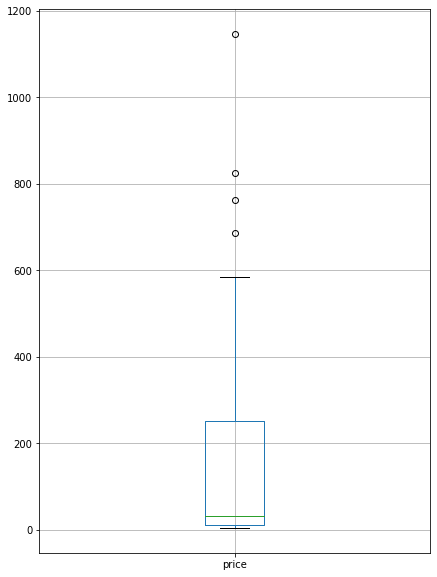

In [229]:
bought_product_df = sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"]
bought_product_df = bought_product_df.replace([np.inf, -np.inf], np.nan)
bought_product_df = bought_product_df.dropna()
df = pd.merge(bought_product_df, product_df, on='product_id', how='inner')
df = df.groupby(df["price"])["price"].count().to_frame()
print(df.nlargest(10, 'price'))
plt.figure(figsize = ( 7 , 10 ))
df.boxplot("price")

### Aktywność użytkowników w danych miesiącach

In [230]:
user_activity = sessions_df[["event_type", "timestamp"]].copy()
user_activity["year"] = pd.DatetimeIndex(user_activity["timestamp"]).year
user_activity["month"] = pd.DatetimeIndex(user_activity["timestamp"]).month
user_activity["day"] = pd.DatetimeIndex(user_activity["timestamp"]).day
user_activity["date"] = pd.DatetimeIndex(user_activity["timestamp"]).date

user_activity

,event_type,timestamp,year,month,day,date
session_id,,,,,,
124,VIEW_PRODUCT,2019-12-31 20:23:33,2019,12,31,2019-12-31
124,VIEW_PRODUCT,2019-12-31 20:27:12,2019,12,31,2019-12-31
124,VIEW_PRODUCT,2019-12-31 20:30:41,2019,12,31,2019-12-31
124,VIEW_PRODUCT,2019-12-31 20:35:19,2019,12,31,2019-12-31
124,VIEW_PRODUCT,2019-12-31 20:36:45,2019,12,31,2019-12-31
...,...,...,...,...,...,...
46764,VIEW_PRODUCT,2021-01-02 23:47:34,2021,1,2,2021-01-02
46764,VIEW_PRODUCT,2021-01-02 23:51:55,2021,1,2,2021-01-02
46764,VIEW_PRODUCT,2021-01-02 23:55:05,2021,1,2,2021-01-02


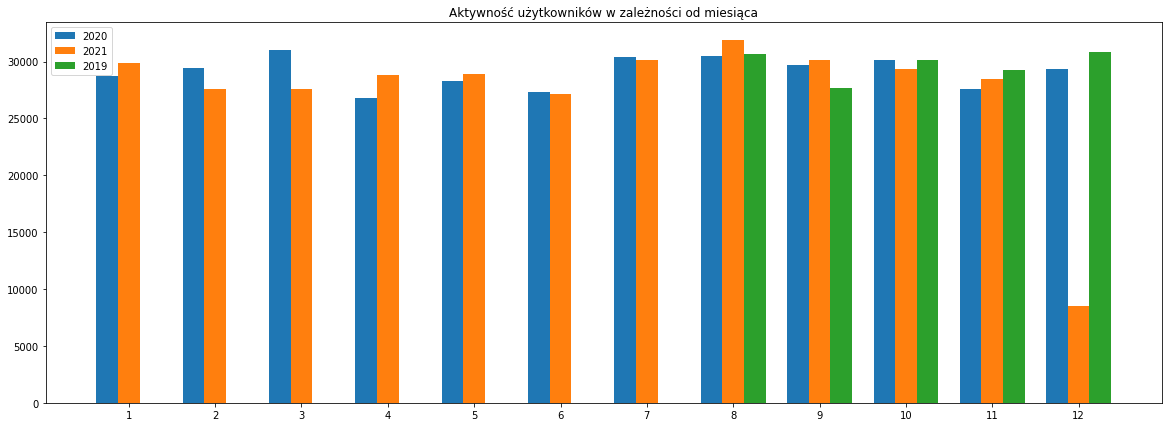

In [231]:
years = user_activity["year"].value_counts().to_dict().keys()
months = range(1, 13)

df_list = []
for index, year in enumerate(years):
    user_activity_year =  user_activity[user_activity.year.eq(year)]
    df = user_activity_year.groupby(user_activity_year["month"])["month"].count().to_dict()
    
    for num_month in months:
        if num_month not in df.keys(): 
            df[num_month] = 0 
            
    df_list.append([j for _,j in sorted(df.items())])


show_plot_for_years(years, months, df_list, "Aktywność użytkowników w zależności od miesiąca")

<AxesSubplot:title={'center':'Aktywność użytkownika w kolejnych dniach miesiąca'}, xlabel='day'>

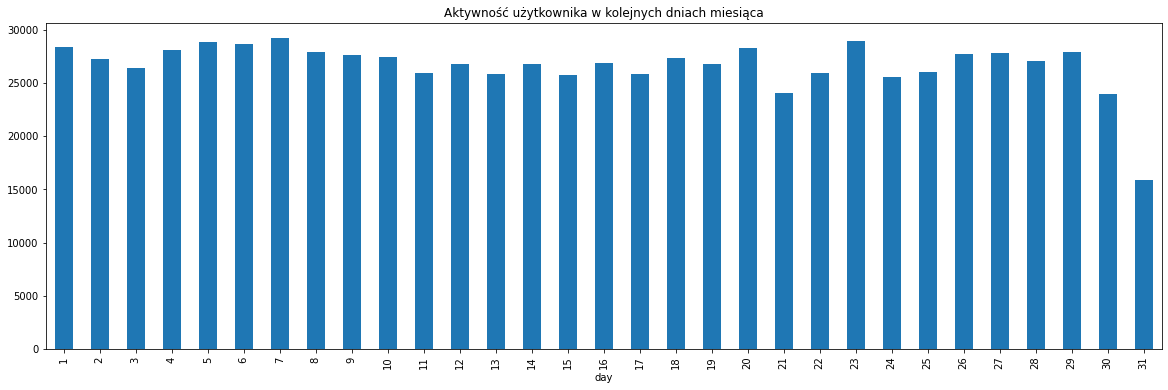

In [232]:
fig, axs = plt.subplots(figsize=(20, 6))
user_activity.groupby(user_activity["day"])["day"].count().plot(kind='bar', ax=axs, title="Aktywność użytkownika w kolejnych dniach miesiąca") 

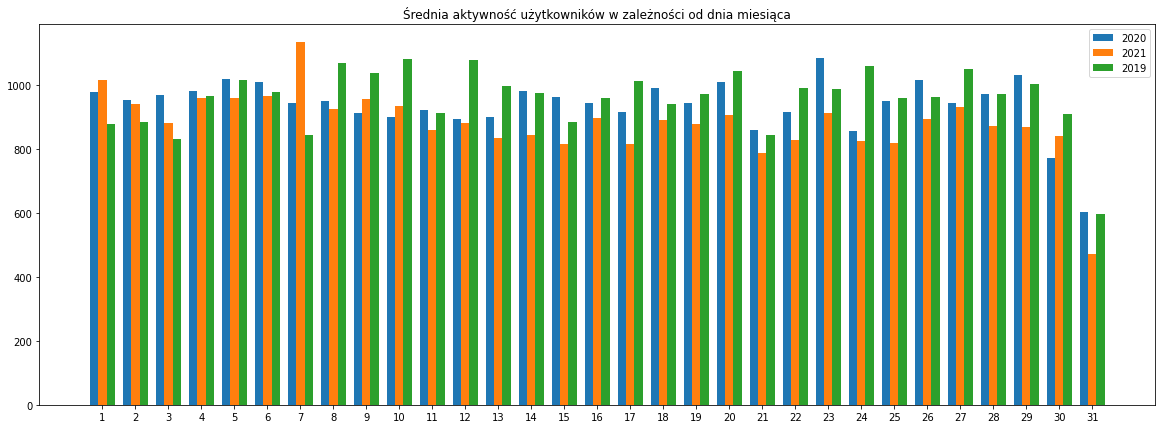

In [233]:
years = user_activity["year"].value_counts().to_dict().keys()
days = range(1, 32)

df_list = []
for index, year in enumerate(years):
    user_activity_year =  user_activity[user_activity.year.eq(year)]
    df = user_activity_year.groupby(user_activity_year["day"])["day"].count().to_dict()
    
    for num_day in days:
        if num_day not in df.keys(): 
            df[num_day] = 0 
            
    months_amount = len(user_activity_year.groupby(user_activity_year['month'])["month"].count())
    df = dict(sorted(df.items())).values()
    df_list.append(np.divide(list(df), months_amount))


show_plot_for_years(years, days, df_list, "Średnia aktywność użytkowników w zależności od dnia miesiąca")

Aktywność użytkowników jest podobna w każdym miesiącu oraz każdego dnia - żadna data nie wyróżnia się znacząco od innych.

<AxesSubplot:>

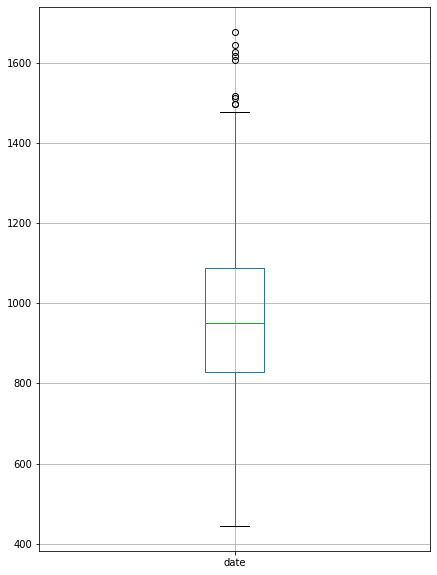

In [234]:
df = user_activity.groupby(user_activity["date"])["date"].count().to_frame()

plt.figure(figsize = ( 7 , 10 ))

df.boxplot("date")

Powyżej znajduje się średnia liczba wizyt dziennie.

### Liczba zamówień w zależności od wysokości promocji

<AxesSubplot:title={'center':'Liczba kupionych produktów w zależności od promocji'}, xlabel='offered_discount'>

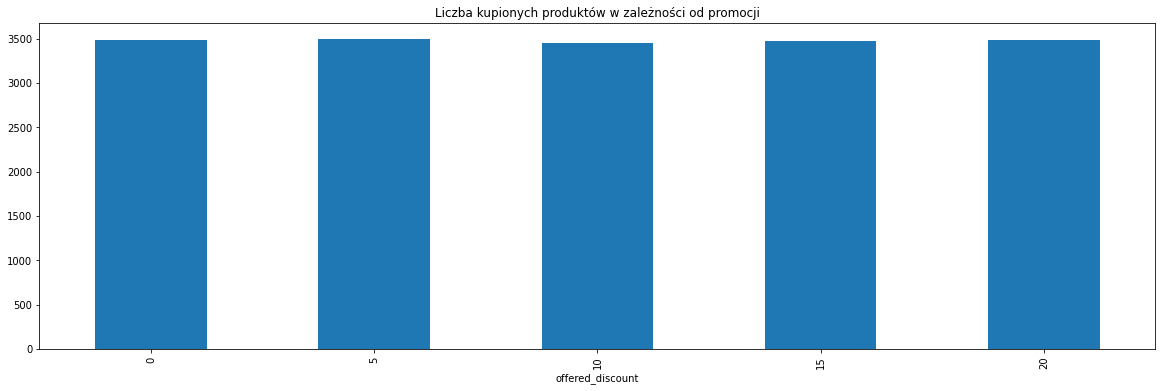

In [235]:
fig, axs = plt.subplots(figsize=(20, 6))
bought_product_df.groupby(bought_product_df["offered_discount"])["offered_discount"].count().plot(kind='bar', ax=axs, title="Liczba kupionych produktów w zależności od promocji") 

### Liczba wyświetleń produktów z danych kategorii

In [236]:
df = pd.merge(sessions_df, product_df, on='product_id', how='inner')

<AxesSubplot:title={'center':'Liczba wyświetlonych produktów w podanej kategorii'}, xlabel='category_path'>

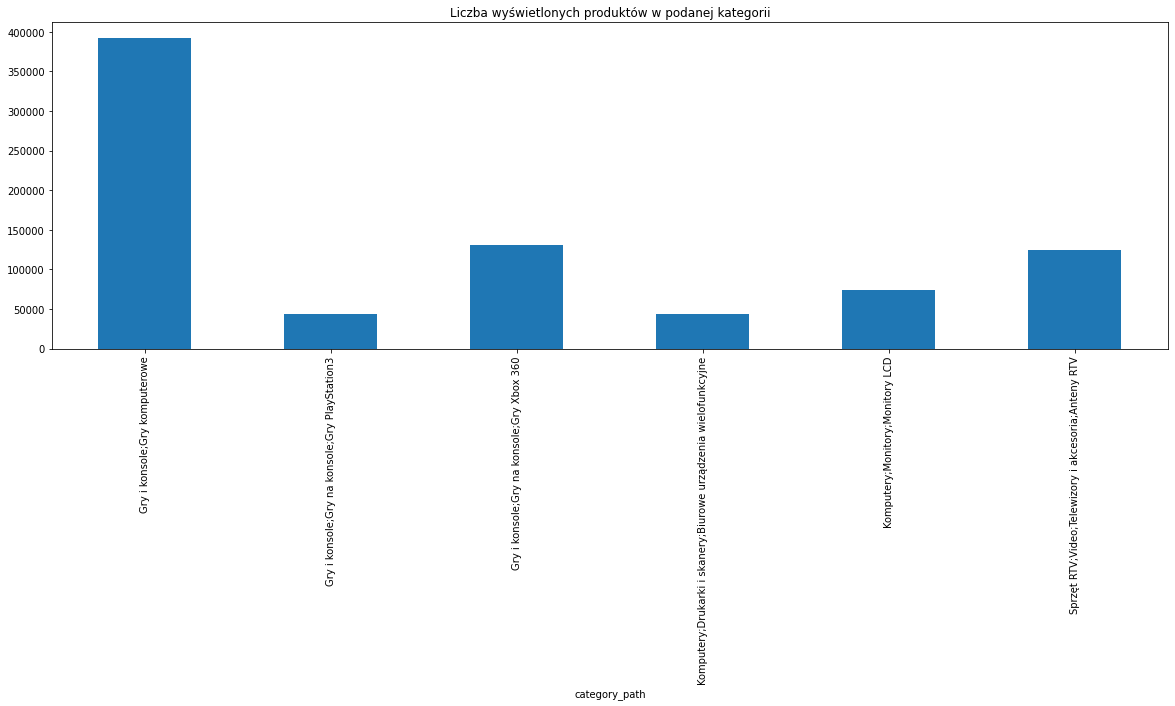

In [237]:
fig, axs = plt.subplots(figsize=(20, 6))
df[df["event_type"] == "VIEW_PRODUCT"].groupby('category_path')["category_path"].count().plot(kind='bar', ax=axs, title="Liczba wyświetlonych produktów w podanej kategorii") 

In [238]:
view_from_category_df = pd.merge(sessions_df[sessions_df['event_type'] == "VIEW_PRODUCT"], product_df, on='product_id', how='inner')
view_from_category_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2019-12-31 20:23:33,103,1114,VIEW_PRODUCT,5,NaN,Brink (PC),Gry i konsole;Gry komputerowe,32.99
1,2019-12-30 15:40:58,109,1114,VIEW_PRODUCT,10,NaN,Brink (PC),Gry i konsole;Gry komputerowe,32.99
2,2019-12-30 18:17:53,270,1114,VIEW_PRODUCT,15,NaN,Brink (PC),Gry i konsole;Gry komputerowe,32.99
3,2019-12-31 10:04:06,366,1114,VIEW_PRODUCT,15,NaN,Brink (PC),Gry i konsole;Gry komputerowe,32.99
4,2019-12-30 12:23:19,370,1114,VIEW_PRODUCT,15,NaN,Brink (PC),Gry i konsole;Gry komputerowe,32.99
...,...,...,...,...,...,...,...,...,...
808811,2021-01-02 19:11:46,272,1155,VIEW_PRODUCT,5,NaN,The Sims 3 Kariera (PC),Gry i konsole;Gry komputerowe,31.90
808812,2021-01-01 11:37:51,294,1155,VIEW_PRODUCT,10,NaN,The Sims 3 Kariera (PC),Gry i konsole;Gry komputerowe,31.90
808813,2021-01-01 22:18:29,302,1155,VIEW_PRODUCT,20,NaN,The Sims 3 Kariera (PC),Gry i konsole;Gry komputerowe,31.90
808814,2021-01-02 15:21:04,340,1155,VIEW_PRODUCT,0,NaN,The Sims 3 Kariera (PC),Gry i konsole;Gry komputerowe,31.90


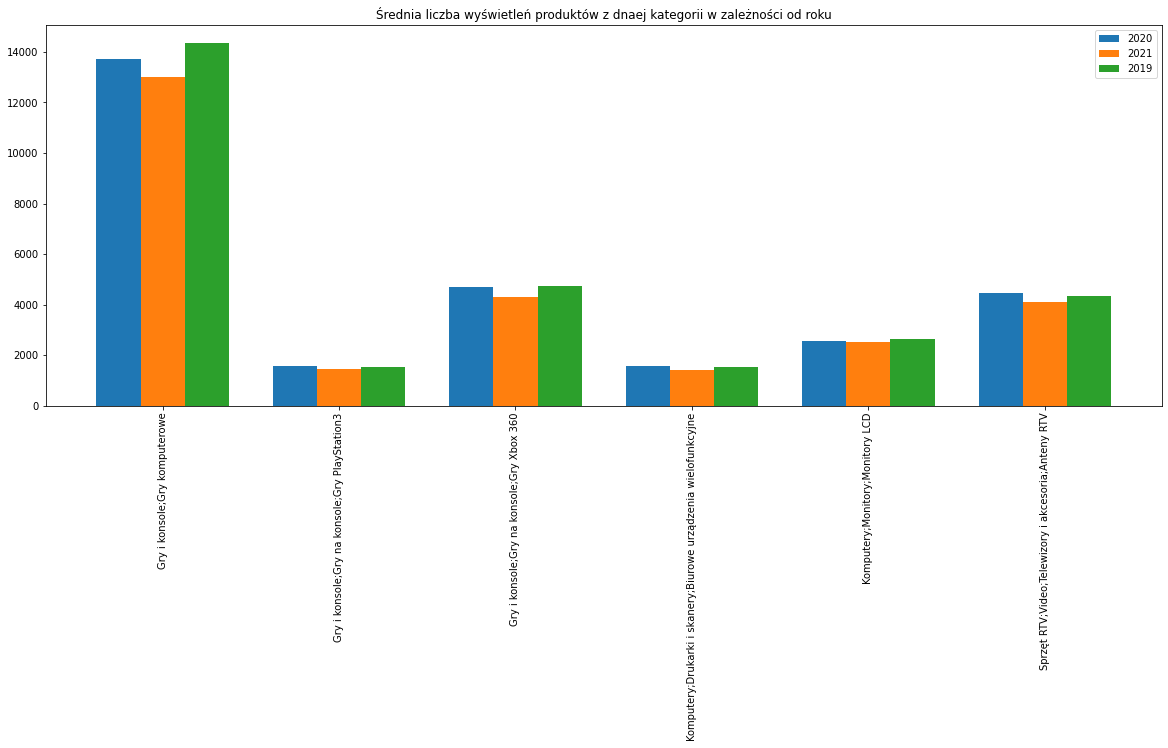

In [239]:
years = view_from_category_df["timestamp"].dt.year.value_counts().to_dict().keys()
categories = view_from_category_df.groupby(view_from_category_df["category_path"])["category_path"].count().to_dict().keys()
df_list = []
for index, year in enumerate(years):
    view_from_category_year = view_from_category_df[view_from_category_df.timestamp.dt.year.eq(year)]
    df = view_from_category_year.groupby(view_from_category_year["category_path"])["category_path"].count().to_dict()
    month_amount = len(view_from_category_year.groupby(view_from_category_year['timestamp'].dt.month)["timestamp"].count())
    df = dict(sorted(df.items())).values()
    df_list.append(np.divide(list(df), month_amount))

show_plot_for_years(years, categories, df_list, "Średnia liczba wyświetleń produktów z dnaej kategorii w zależności od roku", rotation=90)

Na powyższym wykresie można zaobserwować, iż liczba wyświetleń produktów jest zdecydowanie największa dla gier komputerowych, jednak liczba zamówień w każdej z tych kategorii jest podobna. 

## Wnioski

Spodziewałyśmy się, że na wykresach, które stworzyłyśmy, zostanie wykryta zależność liczby kupionych produktów w zależności od promocji. Niestety nie udało wykryć się tej zależności. Dodatkowo nie znalazłyśmy zależności między liczbą zamówień a przedziałami czasowymi (np. Black Friday, okres świąteczny czy też początek/koniec miesiąca w momencie, gdy użytkownicy dostają wypłaty). Udało nam się zauważyć, iż produkty z konkretnych kategorii (np. gry komputerowe) są wyświetlane przez użytkowników częściej niż produkty z innych. Dodatkowo na przestrzeni lat, zauważyłyśmy, iż produkty z kategorii Biurowe urządzenia wielofunkcyjne mają tendencję wzrostową, zaś gry Xbox 360 mają tendencję spadkową. 

Dotąd zebrane dane nie pokazują zależności, których spodziewałybyśmy się w codziennym życiu.